In [39]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# path = "/content/gdrive/My Drive/Colab Notebooks"

In [1]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import joblib

In [38]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

from fastai.tabular import *
from fastai.tabular.all import *
from fastai.tabular.data import *
from fastai.tabular.learner import *

In [4]:
data = pd.read_csv("data_shuf.csv")
alist = data.columns.to_list()
alist

['pop2012',
 'night',
 'road_len',
 'city_pop',
 'cen_dist',
 'land_cover',
 'city_id',
 'X',
 'Y']

In [5]:
alist = ['pop2012', 'night', 'road_len', 'city_pop', 'cen_dist', 'X', 'Y', 'land_cover','city_id']
data = data[alist]

In [6]:
data.describe()

,pop2012,night,road_len,city_pop,cen_dist,X,Y,land_cover,city_id
count,745373.000000,745373.000000,745373.000000,745373.000000,745373.000000,745373.000000,745373.000000,745373.000000,745373.000000
mean,0.007360,0.016975,0.088757,0.326192,0.309736,0.501763,0.491592,6.635601,8.075452
std,0.031053,0.042659,0.123813,0.317179,0.165388,0.229234,0.223515,1.988893,4.730038
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.001257,0.000000,0.112451,0.188068,0.323764,0.312236,7.000000,5.000000
50%,0.000032,0.002658,0.042683,0.202492,0.285789,0.501548,0.490411,7.000000,8.000000
75%,0.001060,0.010131,0.127079,0.333183,0.406160,0.682540,0.665753,8.000000,12.000000
max,1.000000,1.000000,0.989409,1.000000,1.000000,1.000000,1.000000,11.000000,16.000000


In [7]:
cat_names = alist[-2:]
cont_names = alist[1:-2]
y_names = alist[0]
procs = [Categorify,]

In [8]:
percent, length = 0.8, len(data.axes[0])
stop = int(percent * length)
splits = [list(range(stop)), list(range(stop,length))]

In [9]:
to = TabularPandas(data, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=y_names, splits=splits)

In [10]:
len(to.xs),len(to.train),len(to.valid)

(745373, 596298, 149075)

In [11]:
xs, y = to.xs,to.y
train_xs,train_y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Decision Tree

In [12]:
def rmse(y,y_pred): return mean_squared_error(y,y_pred,squared=False)

In [13]:
dt = DecisionTreeRegressor(max_leaf_nodes=10, min_samples_leaf=25)
dt.fit(train_xs, train_y);

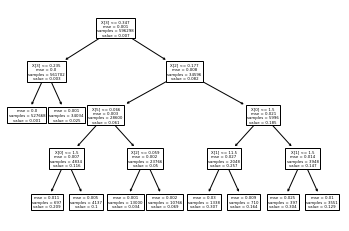

In [14]:
plot_tree(dt);

In [15]:
dt.get_n_leaves(), len(train_xs)

(10, 596298)

In [16]:
train_rmse = rmse(dt.predict(train_xs), train_y)
valid_rmse = rmse(dt.predict(valid_xs), valid_y)

In [17]:
std = data.describe().to_dict()['pop2012']['std']
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.01865095313208803, 0.01823642536612159, 0.6551069901547166)

## Random Forest

In [18]:
param_grid = [{'n_estimators':[20], 'max_samples':[200_00], 'max_features': [0.5], 'min_samples_leaf':[5, 8, 10], 'max_depth': [10, 12, 14]}]
rf_test = RandomForestRegressor()

In [ ]:
rf_grid_search = GridSearchCV(rf_test, param_grid, cv=4, scoring='neg_mean_squared_error')
rf_grid_search.fit(train_xs,train_y)

In [ ]:
rf_grid_search.best_params_

In [18]:
n_estimators = 500
max_samples = 200_00
max_features = 0.5
min_samples_leaf = 5

In [19]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
    max_samples=max_samples, max_features=max_features,
    min_samples_leaf=min_samples_leaf, oob_score=True)

In [20]:
import time
start = time.time()
m = rf.fit(train_xs, train_y);
end = time.time()
print("Time:", end-start)

Time: 80.82889199256897


In [21]:
train_rmse = rmse(rf.predict(train_xs), train_y)
valid_rmse = rmse(rf.predict(valid_xs), valid_y)

In [22]:
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.014313295078176615, 0.014426411832639867, 0.7841651265901359)

In [23]:
train_preds = np.stack([t.predict(train_xs) for t in rf.estimators_])
valid_preds = np.stack([t.predict(valid_xs) for t in rf.estimators_])
train_preds.shape, valid_preds.shape

((500, 596298), (500, 149075))

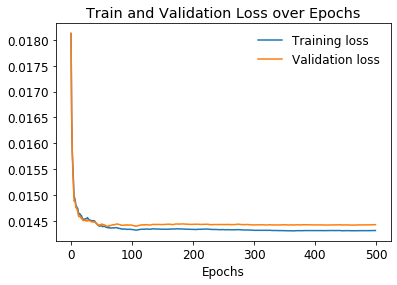

In [24]:
t = [rmse(train_preds[:i+1].mean(0), train_y) for i in range(0, n_estimators)]
v = [rmse(valid_preds[:i+1].mean(0), valid_y) for i in range(0, n_estimators)]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

In [25]:
for name, score in zip(alist[1:], rf.feature_importances_):
    print('%s: %f' %(name, 100 *score)+"%")

night: 13.867325%
road_len: 4.017821%
city_pop: 24.084534%
cen_dist: 37.737926%
X: 2.698857%
Y: 12.484451%
land_cover: 2.539684%
city_id: 2.569402%


In [26]:
# Save the model
joblib_file = "forest.pkl"
joblib.dump(m, joblib_file)
print('Model Saved!')

Model Saved!


## Gradient Boosting

In [48]:
param_grid = [{'n_estimators':[20], 'max_depth': [7, 8, 9], 'learning_rate':[0.1, 0.3, 0.5], 'min_samples_leaf':[20, 25, 30]}]
gbrt_test = GradientBoostingRegressor()

In [49]:
gbrt_grid_search = GridSearchCV(gbrt_test, param_grid, cv=5, scoring='neg_mean_squared_error')
gbrt_grid_search.fit(train_xs,train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [50]:
gbrt_grid_search.best_params_

{'learning_rate': 0.3,
 'max_depth': 8,
 'min_samples_leaf': 20,
 'n_estimators': 20}

In [27]:
n_estimators = 150
max_depth = 8
lr = 0.3
min_samples_leaf = 20

In [28]:
gbrt = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=lr, min_samples_leaf=min_samples_leaf)
m = gbrt.fit(train_xs,train_y)

In [29]:
train_rmse = rmse(gbrt.predict(train_xs), train_y)
valid_rmse = rmse(gbrt.predict(valid_xs), valid_y)

In [30]:
errors = [rmse(valid_y_pred, valid_y) for valid_y_pred in gbrt.staged_predict(valid_xs)]
best_n_estimators = np.argmin(errors)
print(best_n_estimators)

140


In [31]:
gbrt_best = GradientBoostingRegressor(max_depth=max_depth, n_estimators=best_n_estimators, learning_rate=lr, min_samples_leaf=min_samples_leaf)
m = gbrt_best.fit(train_xs,train_y)

In [32]:
train_rmse = rmse(gbrt_best.predict(train_xs), train_y)
valid_rmse = rmse(gbrt_best.predict(valid_xs), valid_y)

In [33]:
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.009436869510446675, 0.012376095133934919, 0.8411554775555448)

In [34]:
for name, score in zip(alist[1:], m.feature_importances_):
    print('%s: %f' %(name, 100 *score)+"%")

night: 7.119675%
road_len: 5.727978%
city_pop: 21.264036%
cen_dist: 48.083181%
X: 2.252046%
Y: 9.622838%
land_cover: 2.578108%
city_id: 3.352138%


In [35]:
# Save the model
joblib_file = "gbrt.pkl"
joblib.dump(m, joblib_file)
print('Model Saved!')

Model Saved!


## Now Prediction!

In [36]:
def predict_tabular(data_ori, xs, joblib_file, pred_name, pop_max):  
    data_pred = pd.read_csv(data_ori)
    # Load from file
    joblib_model = joblib.load(joblib_file)
    preds = joblib_model.predict(xs)
    # Transform to the pre-normalized state
    preds = preds * pop_max

    # Copy in the csv
    data_pred[pred_name] = preds
    data_pred[pred_name] = data_pred[pred_name].apply(lambda x: max(0,x))
    data_pred.to_csv(data_ori,index=False)
    print('File Exported!')

In [37]:
data_ori = 'data2012.csv'
data_norm = pd.read_csv('data_new.csv')
data_norm = data_norm[alist[1:]]
to = TabularPandas(data_norm, procs=procs, cat_names=cat_names, cont_names=cont_names)
predict_tabular(data_ori, xs=to.xs, joblib_file="forest.pkl", pred_name='pop_pred_forest', pop_max=85729.664432)
predict_tabular(data_ori, xs=to.xs, joblib_file="gbrt.pkl", pred_name='pop_pred_gbrt', pop_max=85729.664432)

File Exported!
File Exported!


In [66]:
pd.DataFrame({'city': data_pred['fua_name'].unique(),
              'population (2012)': data_pred['city_pop'].unique(), 
              'population (202001)': data_pred.groupby(['fua_name'])['pop01'].transform(sum).unique()})
# area 